In [68]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 

In [69]:

training_dir = r"C:\Users\marad\OneDrive\Desktop\DB_project\archive\167"
train_batch_size = 32
train_number_epochs = 10

In [70]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class SiameseNetworkDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        
        for filename in os.listdir(self.data_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                self.images.append(os.path.join(self.data_dir, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, 0  # All images belong to a single class, so we can assign a fixed label value to all of them
    

In [71]:

image_transforms =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1), # Convert grayscale to RGB
    transforms.ToTensor(),
])

siamese_dataset = SiameseNetworkDataset(training_dir, transform=image_transforms)



In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(80000,500)
        self.fc2 = nn.Linear(1000,500)
        
    def forward_once(self, x):
        x = torch.mean(x, dim=1, keepdim=True) # convert to grayscale
        output = self.cnn1(x)
        output = self.conv2(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2




In [73]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [74]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [75]:
# Declare Siamese Network
net = SiameseNetwork()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr= 0.0001)

In [76]:


train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=32)

In [77]:
import matplotlib.pyplot as plt

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss over time')
    plt.show()

Epoch number 0
 Current loss 3.9288458824157715

Epoch number 1
 Current loss 0.0

Epoch number 2
 Current loss 1.562498741503049e-11

Epoch number 3
 Current loss 0.0

Epoch number 4
 Current loss 1.562498741503049e-11

Epoch number 5
 Current loss 0.0

Epoch number 6
 Current loss 0.0

Epoch number 7
 Current loss 0.0

Epoch number 8
 Current loss 0.0

Epoch number 9
 Current loss 0.0



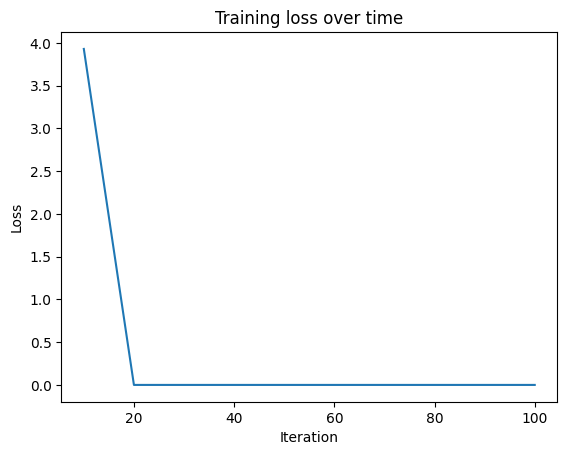

In [33]:
import random

counter = []
loss_history = []
iteration_number = 0

for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_loader, 0):
        img0, img1 , label = data
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output1, output2 = net(img0,img1)
        loss_contrastive = criterion(output1, output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter, loss_history)



In [34]:
siamese_net = SiameseNetwork()
# Save the trained model
torch.save(siamese_net.state_dict(), 'siamese_net.pt')

In [93]:
import matplotlib.pyplot as plt

def main(train_path, valid_path, input_img_path):
    # Define the transform for loading images
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the datasets
    train_dataset = SiameseNetworkDataset(train_path, transform)
    valid_dataset = SiameseNetworkDataset(valid_path, transform)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

    # Create the Siamese Network and load the pretrained weights
    siamese_net = SiameseNetwork()
    siamese_net.load_state_dict(torch.load('siamese_net.pt'))

    # Set the Siamese Network to evaluation mode
    siamese_net.eval()

    # Load the input image and convert it to a tensor
    input_img = Image.open(input_img_path)
    input_tensor = transform(input_img).unsqueeze(0)

    # Compute the feature vector for the input
    with torch.no_grad():
        input_features = siamese_net.forward_once(input_tensor)

    # Compute the similarity between the input image and each image in the validation set
    similarities = []
    for i, data in enumerate(valid_loader):
        valid_tensor = data[0] # Unpack the tensor from the list
        with torch.no_grad():
            valid_features = siamese_net.forward_once(valid_tensor)
        similarity = image_similarity(input_features, valid_features)
        similarities.append((i, similarity))

    # Sort the similarities in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Display the 10 most similar images
#     print("Input Image:")
#     input_img.show()
    print("\nTop 10 Similar Images:")
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
    for i in range(10):
        index, similarity = similarities[i]
        similar_img = Image.open(valid_dataset.images[index])
        row, col = i // 5, i % 5
        axes[row, col].imshow(similar_img)
        axes[row, col].set_title("Similarity: {:.2f}".format(similarity))
        axes[row, col].axis('off')
    plt.show()


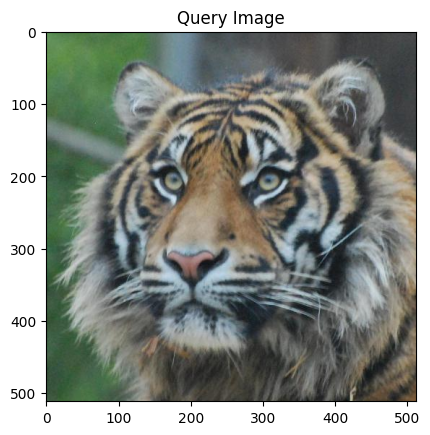

In [94]:
import matplotlib.pyplot as plt

# Display the query image
query_image = Image.open(input_img_path)
plt.imshow(query_image)
plt.title('Query Image')
plt.show()


Top 10 Similar Images:


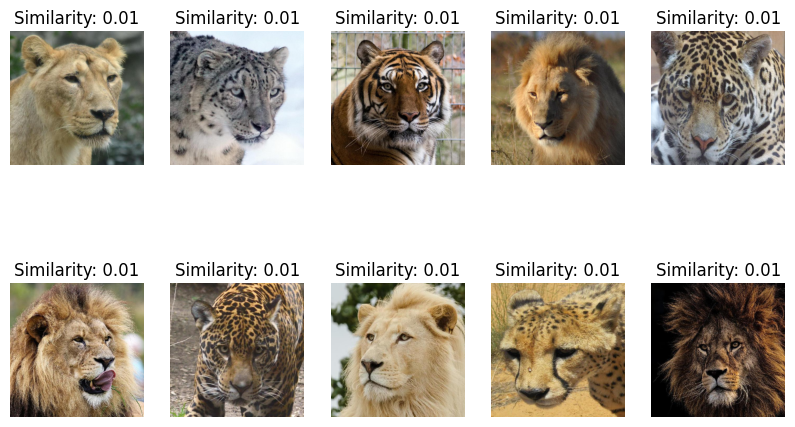

In [95]:
train_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\train"
valid_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\val"
input_img_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\archive\167\15.jpg"

main(train_path, valid_path, input_img_path)